In [2]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
from pathlib import Path
import os
from os.path import isfile, join
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import random
from vidaug import augmentors as va
from PIL import Image, ImageOps, ImageDraw, ImageFilter
import time
from torchvision import datasets, models, transforms

In [3]:
# TODO:
#     solve actual epoch issue 
#     solve fps issue

In [4]:
!ls ../data/video

dark_1.mp4      long_dst_1.mp4  mi_2.mp4        temporaly_moved
dark_2.mp4      mary_1.mp4      mi_3.mp4        tum_4.mp4
home_1.mp4      mary_2.mp4      old             tum_6.mp4
home_2.mp4      mi_1.mp4        out_1.mp4       tum_8.mp4


In [5]:
args = {
    "video_dir": "../data/video/temporaly_moved/",
    "markup_dir": "../data/markup/",
    "std_height": 2024,
    "std_width": 2024,
    "in_channels": 16,#3,
    "dropout": 0.3,
    "hidden_dim": 1024,
    "random_seed": 123456,
    "max_seq_len": 10,
    "batch_size": 1,
    "p_blur" : 0.5,
    "p_rotate" : 0.5,
    "p_translate" : 0.7,
    "p_flip" : 0.4,
    "p_shear" : 0.4,
    "max_shear": 10,
    "max_rotate": 10,
#     "arg_blur": 3,
    "arg_blur": 1,
    "arg_rotate": 10,
    "arg_translate": [50,50],
    "arg_shear": [0.15,0.15],
    "arg_salt": [500,100,1000],
    "arg_pepper": [500,100,1000],
    "do_augmentation": True,
    "use_cuda": True,
    "clip": 0.6,
    "num_iterations": 10,
    
}
args["video_path"] = Path(args["video_dir"])
args["markup_path"] = Path(args["markup_dir"])

np.random.seed(args["random_seed"])
random.seed(args["random_seed"])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() and args["use_cuda"] else "cpu")

In [7]:
# first W, then H

In [8]:
list_videos = [f for f in os.listdir(args["video_path"]) if isfile(join(args["video_path"],f)) and f[-4:] == ".mp4"]
list_videos

['video_home_2.mp4', 'out_4.mp4', 'out_5.mp4', 'out_2.mp4']

In [9]:
[(vid, int(cv2.VideoCapture(str(args["video_path"]/vid))\
                                 .get(cv2.CAP_PROP_FRAME_COUNT)))
                            for vid in list_videos]

[('video_home_2.mp4', 1916),
 ('out_4.mp4', 1007),
 ('out_5.mp4', 1647),
 ('out_2.mp4', 1576)]

In [59]:
class Dataloader_new(nn.Module):
    def __init__(self, args):
        super(Dataloader_new, self).__init__()
        self.args = args
        self.list_videos = [f for f in os.listdir(args["video_path"]) if isfile(join(args["video_path"],f)) 
                            and f[-4:] == ".mp4"]
        self.list_weights = [int(cv2.VideoCapture(str(self.args["video_path"]/vid))\
                                 .get(cv2.CAP_PROP_FRAME_COUNT))
                            for vid in self.list_videos]
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()
        self.arr_weights = np.array(self.list_weights)
        self.choice_probs = self.arr_weights / sum(self.arr_weights)
        self.max_resizer = nn.AdaptiveMaxPool2d(output_size = (args["std_width"],args["std_height"]))
        
    def scale_and_pad(self, frame, target):
        """
        Makes a central crop [1x1-img] of the frame and produces new target position
        args:
            frame [PIL_Image] - non-scaled image
            target [int, int] - w, h pair of the target 
        return:
            new_frame [PIL_Image] - scaled & padded image
            new_target [int, int] - w, h pair of the new target 
        """
        
        def get_target_on_cen_cropped_frame(single_target_unscaled, old_size):
            x, y = single_target_unscaled
            center_x = old_size[0] / 2.
            center_y = old_size[1] / 2.
            if x < center_x - min(old_size) / 2 \
                    or x > center_x + min(old_size) / 2 \
                    or y < center_y - min(old_size) / 2 \
                    or y < center_y - min(old_size) / 2:
                
                new_target = [0,0]
            else:
                offset_x = x - center_x
                new_x = min(old_size) / 2 + offset_x
                
                offset_y = y - center_y
                new_y = min(old_size) / 2 + offset_y
                
                if old_size[0] > old_size[1]:
                    new_target = [int(new_x), y]
#                     print("HORIZONTAL")
                else:
                    new_target = [x, int(new_y)]
#                     print("VERTICAL")
            return new_target

        old_size = frame.size # in (width, height) format
        central_crop = transforms.CenterCrop([min(old_size),min(old_size)])
        
        tmp_frame = central_crop(frame)
        tmp_target = get_target_on_cen_cropped_frame(target, old_size)
        
        to_standart = transforms.Compose([transforms.Resize((args["std_width"],args["std_height"]))])
        
        new_frame = to_standart(tmp_frame)
        
        
        avg_p = nn.AdaptiveAvgPool2d(output_size = (224,224))
        max_p = nn.AdaptiveMaxPool2d(output_size = (224,224))

        to_pil = transforms.ToPILImage()
        to_tensor = transforms.ToTensor()
        to_pil(avg_p(to_tensor(frames[2])))
        
        
        ratio_x = 2. * ( tmp_target[0] ) / tmp_frame.size[0] - 1.
        ratio_y = 2. * ( tmp_target[1] ) / tmp_frame.size[1] - 1.
        new_x = 224/2 + 224./2 * ratio_x
        new_y = 224/2 + 224./2 * ratio_y
        new_target = [int(new_x), int(new_y)]
        
        return new_frame, new_target
        
#         return tmp_frame, tmp_target
    
    def load_vid_and_markup(self):
        """
        Loads video as list of frames (PIL images) and markup as list of (x,y) - target position
        return:
            frames - list [max_seq_len] of PIL_Images [std_width, std_height]
            target - tensor of shape [max_seq_len, 2]
        """
        video_name = np.random.choice(self.list_videos,replace=False, p = self.choice_probs)
        # get markup
        with open(self.args["markup_path"] / (video_name + ".markup.json")) as json_file:
            j = json.load(json_file)
            lst_tmp = j["target_pos"]
            old_h = j["height"]
            old_w = j["width"]
            target_unscaled_all = [xi[1] for xi in lst_tmp]
        # get video frames
        vid_path = str(self.args["video_path"] / (video_name))
        cap = cv2.VideoCapture(vid_path)
        frames_list_unscaled = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            frame = self.to_pil(frame)
            frames_list_unscaled.append(frame)
        # prepare output
#         print(len(frames_list_unscaled))
#         print(len(target_unscaled_all))
        print(vid_path)
        
        assert len(frames_list_unscaled) == len(target_unscaled_all)#.shape[0]
        target_scaled_list = []
        frames_list = []
        for i in range(len(frames_list_unscaled)):
            new_frame, new_target = self.scale_and_pad(frames_list_unscaled[i], target_unscaled_all[i])
            frames_list.append(new_frame)
            target_scaled_list.append(new_target)
        frames_list_unscaled = None
        target_unscaled_all = None
        target_points = torch.tensor(target_scaled_list)
        cur_length = len(frames_list)
        if cur_length > self.args["max_seq_len"]:
            # get a truncated part of the video
            begin = np.random.randint(low=0, high= cur_length - self.args["max_seq_len"])
            end = begin + self.args["max_seq_len"]
            frames_fin = frames_list[begin:end]
            target_fin = target_points[begin:end, :]
        else:
            # complement to standard length
            add_size = self.args["max_seq_len"] - cur_length
            frames_to_add = [self.to_pil(torch.zeros(3, self.args["std_height"], self.args["std_width"])) 
                      for i in range(add_size)]
            target_to_add = torch.zeros([add_size, 2], dtype=torch.long)
            
            frames_fin = frames_list + frames_to_add
            target_fin = torch.cat([target_points, target_to_add], dim = 0)
        return frames_fin, target_fin

In [11]:
# dl = Dataloader_new(args)
# frames, target = dl.load_vid_and_markup()

In [12]:
class Augmentor(nn.Module):
    def __init__(self, args):
        super(Augmentor, self).__init__()
        self.args = args
        self.arg_blur = args["arg_blur"]
        self.arg_rotate = args["arg_rotate"]
        self.arg_translate = args["arg_translate"]
#         self.arg_crop = args["arg_crop"]
#         self.arg_flip = args["arg_flip"]
        self.arg_shear = args["arg_shear"]
#         self.sometimes_blur = lambda aug: va.Sometimes(args["p_blur"], aug)
        self.sometimes_rotate = lambda aug: va.Sometimes(args["p_rotate"], aug)
        self.sometimes_translate = lambda aug: va.Sometimes(args["p_translate"], aug)
#         self.sometimes_crop = lambda aug: va.Sometimes(args["p_crop"], aug)
        self.sometimes_flip = lambda aug: va.Sometimes(args["p_flip"], aug)
        self.sometimes_shear = lambda aug: va.Sometimes(args["p_shear"], aug)
        self.seq_1 = va.Sequential([
            self.sometimes_rotate(va.RandomRotate(args["arg_rotate"])),
            self.sometimes_flip(va.HorizontalFlip()),
#             self.sometimes_blur(va.GaussianBlur(np.random.randint(1, args["arg_blur"])))
        ])
        self.seq_2 = va.Sequential([
            self.sometimes_shear(va.RandomShear(*args["arg_shear"])),
            self.sometimes_flip(va.HorizontalFlip()),
#             self.sometimes_blur(va.GaussianBlur(np.random.randint(1, args["arg_blur"])))
        ])
        self.seq_3 = va.Sequential([
            self.sometimes_rotate(va.RandomRotate(args["arg_rotate"])),
        ])
        self.seq_4 = va.Sequential([
            self.sometimes_translate(va.RandomTranslate(*args["arg_translate"])),
            self.sometimes_flip(va.HorizontalFlip()),
        ])
#         self.salt = va.Salt(np.random.choice(args["arg_salt"]))
#         self.pepper = va.Pepper(np.random.choice(args["arg_pepper"]))
        
        
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()
    def transform(self, frames, val=1):
        """
        args:
            frames - list of PIL Images [seq_len * 2]
            val - random int in [0, 1]
        return:
            new_frames - list of transformed frames
        """
        if 0 <= val < 0.25:
            frames = self.seq_1(frames)
        elif 0.25 <= val < 0.50:
            frames = self.seq_2(frames)
        elif 0.50 <= val < 0.75:
            frames = self.seq_3(frames)
        else: # 0.75 <= val <= 1:
            frames = self.seq_4(frames)
        return frames
    def apply_transforms(self, frames, target):
        """
        args:
            frames - list [max_seq_len] of PIL_Images [std_width, std_height]
            target - tensor of shape [max_seq_len, 2]
        return:
            new_frames - new_list [max_seq_len] of PIL_Images [std_width, std_height]
            new_target - new_tensor of shape [max_seq_len, 2]
        """
        dumm_trg = []
        for x, y in target.tolist():
            #t = torch.zeros(1,*frames[0].size)
            t = torch.zeros(1, self.args["std_height"], self.args["std_width"])
            t[0, y, x] = 1
            dumm_trg.append(self.to_pil(t))
        composed = frames + dumm_trg
        rand_val = np.random.rand()
        transformed_composed = self.transform(composed, rand_val)
        
        middle = len(transformed_composed)//2
        frames_transformed = transformed_composed[:middle]
        dumm_trg_transformed = transformed_composed[middle:]
        
        target_transformed = []
        assert len(dumm_trg_transformed) == len(target)
        for dumm_trg, real_trg in zip(dumm_trg_transformed, target):
            dumm_tensor = self.to_tensor(dumm_trg).to(device)
            nonzero = dumm_tensor.nonzero()
            if nonzero.shape[0] == 0 or all(real_trg == torch.tensor([0,0])): # target is not on the frame
                target_transformed.append([0,0])
            else:
                y = nonzero.tolist()[0][1] # modif!!!
                x = nonzero.tolist()[0][2]
                target_transformed.append([x,y])
                
                
        target_transformed = torch.tensor(target_transformed).to(device)
        assert target_transformed.shape[0] == len(frames_transformed)
        
        #salt and pepper
        rand_val = np.random.rand()
        #print(frames_transformed)
#         if rand_val < 0.5:
#             frames_transformed = self.salt(frames_transformed)
#         elif 0.5 <= rand_val < 0.95:
#             frames_transformed = self.pepper(frames_transformed)
#         else:
#             pass
        
        return frames_transformed, target_transformed

In [13]:
# da = Augmentor(args)
# fr, tr = da.apply_transforms(frames, target)

In [14]:
class Batcher(nn.Module):
    def __init__(self, args, dataloader, augmentor):
        super(Batcher, self).__init__()
        self.args = args
        self.dl = dataloader
        self.da = augmentor
        self.to_tensor = transforms.ToTensor()
        self.color_norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    def normalize(self, x_y_pair):
        x, y = x_y_pair
        new_x = 2. * ( x ) / 224 - 1
        new_y = 2. * ( y ) / 224 - 1
        return [new_x, new_y]

    def get_batch(self):
        """
        return:
            batch of frames of shape [batch_size, max_seq_len, in_channels, std_height, std_width]
            batch of target of shape [batch_size, max_seq_len, 2]
        """
        batch_frames_lst = []
        batch_target_lst = []
        
        for i in range(self.args["batch_size"]):
            frames, target = self.dl.load_vid_and_markup()
            if self.args["do_augmentation"] == True:
                frames, target = da.apply_transforms(frames, target)
            ###
            
            frames_rgb = [self.color_norm(self.to_tensor(frame)).to(device) for frame in frames]
            frames_rgb = torch.stack(frames_rgb).to(device)
            
            frames_emboss = [frame.filter(ImageFilter.EMBOSS) for frame in frames]
            frames_emboss = [self.to_tensor(frame).to(device) for frame in frames_emboss]
            frames_emboss = torch.stack(frames_emboss).to(device)
            
            frames_edges = [frame.filter(ImageFilter.FIND_EDGES) for frame in frames]
            frames_edges = [self.to_tensor(frame).to(device) for frame in frames_edges]
            frames_edges = torch.stack(frames_edges).to(device)
            
            frames_contour = [frame.filter(ImageFilter.CONTOUR) for frame in frames]
            frames_contour = [self.to_tensor(frame).to(device) for frame in frames_contour]
            frames_contour = torch.stack(frames_contour).to(device)
            
            threshold = 50
            frames_tr50 = [frame.convert("L").point(lambda p: p > threshold and 255) for frame in frames]
            frames_tr50 = [self.to_tensor(frame).to(device) for frame in frames_tr50]
            frames_tr50 = torch.stack(frames_tr50).to(device)
            
            threshold = 100
            frames_tr100 = [frame.convert("L").point(lambda p: p > threshold and 255) for frame in frames]
            frames_tr100 = [self.to_tensor(frame).to(device) for frame in frames_tr100]
            frames_tr100 = torch.stack(frames_tr100).to(device)
            
            threshold = 150
            frames_tr150 = [frame.convert("L").point(lambda p: p > threshold and 255) for frame in frames]
            frames_tr150 = [self.to_tensor(frame).to(device) for frame in frames_tr150]
            frames_tr150 = torch.stack(frames_tr150).to(device)
            
            threshold = 200
            frames_tr200 = [frame.convert("L").point(lambda p: p > threshold and 255) for frame in frames]
            frames_tr200 = [self.to_tensor(frame).to(device) for frame in frames_tr200]
            frames_tr200 = torch.stack(frames_tr200).to(device)
            
            frames = torch.cat([frames_rgb, frames_emboss, frames_edges, frames_contour, 
                                  frames_tr50, frames_tr100, frames_tr150, frames_tr200], dim=1)
            
            batch_frames_lst.append(frames)
        
            lst = []
            for x_y_pair in target:
                tmp = torch.stack(self.normalize(x_y_pair)).to(device)
                lst.append(tmp)
            normilized_xy = torch.stack(lst).to(device)
            
            batch_target_lst.append(normilized_xy)
        batch_frames = torch.stack(batch_frames_lst).to(device)
        batch_target = torch.stack(batch_target_lst).to(device)
        return batch_frames, batch_target

In [15]:
# dl = Dataloader_new(args)
# da = Augmentor(args)
# batcher = Batcher(args, dl, da)

In [14]:
class CNN_RNN(nn.Module):
    def __init__(self, args):
        super(CNN_RNN, self).__init__()
        self.model_ft = models.squeezenet1_0(pretrained=True) # models - global
        self.feature_extract = True
        self.set_parameter_requires_grad(self.model_ft, self.feature_extract)
        self.model_ft.classifier[1] = nn.Conv2d(512, 512, kernel_size=(1,1), stride=(1,1))
        self.model_ft.classifier[3] = torch.nn.AdaptiveMaxPool2d(output_size=(2,2))
        
        self.conv = nn.Sequential(
            nn.Conv2d(args["in_channels"], 32, kernel_size=(3,3), padding = (2,2)),
            nn.Conv2d(32, 64, kernel_size=(5,5), stride=(2,2)),
            nn.MaxPool2d(kernel_size=(3,3), padding = (1,1)),
            nn.Conv2d(64, 64, kernel_size=(5,5), padding = (1,1)),
            nn.Conv2d(64, 128, kernel_size=(5,5), stride=(2,2), padding = (1,1)),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(2,2), padding = (1,1)),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(output_size=(2,2)),
        )
        
        
        self.gru = nn.GRU(input_size=512*4 + 256*4, hidden_size=args["hidden_dim"], bidirectional=False, \
                          batch_first=True)
        self.fc1 = nn.Sequential(
            nn.Linear(args["hidden_dim"], 2)
        )
        
#         self.
    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
#             for param in model.parameters():
#                 param.requires_grad = False
            for name, param in model.named_parameters():
                if "12" in name or "classifier" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
    
    def forward(self, x):
        rgb = x[:,:3,:,:]
        out_sqnet = self.model_ft(rgb)
        out_conv = self.conv(x)
        out_conv = out_conv.view([-1, 256*4])
        out_cnns = torch.cat([out_sqnet, out_conv], dim = 1) 
#         print(out_sqnet.shape)
#         print(out_conv.shape)
#         print(out_cnns.shape)
        
        out_gru = self.gru(out_cnns.unsqueeze(0))[0]
        out_fc = self.fc1(out_gru)
        return out_fc[0]

In [15]:
model = CNN_RNN(args).to(device)

In [16]:
def train_on_batch(model, optimizer, criterion, batch_frames, batch_target):
    model.train()
    loss_log = []
    for mini_batch_frames, mini_batch_target in zip(batch_frames, batch_target):
        pred = model(mini_batch_frames)
        
        optimizer.zero_grad()
        loss = criterion(pred, mini_batch_target.float())
        loss_log.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args["clip"])
        optimizer.step()
    return loss_log

In [17]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [18]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
print("number of learning params: ", sum(p.numel() for p in model.parameters()))

	 model_ft.features.12.squeeze.weight
	 model_ft.features.12.squeeze.bias
	 model_ft.features.12.expand1x1.weight
	 model_ft.features.12.expand1x1.bias
	 model_ft.features.12.expand3x3.weight
	 model_ft.features.12.expand3x3.bias
	 model_ft.classifier.1.weight
	 model_ft.classifier.1.bias
	 conv.0.weight
	 conv.0.bias
	 conv.1.weight
	 conv.1.bias
	 conv.3.weight
	 conv.3.bias
	 conv.4.weight
	 conv.4.bias
	 conv.5.weight
	 conv.5.bias
	 conv.6.weight
	 conv.6.bias
	 gru.weight_ih_l0
	 gru.weight_hh_l0
	 gru.bias_ih_l0
	 gru.bias_hh_l0
	 fc1.0.weight
	 fc1.0.bias
number of learning params:  14837730


In [19]:
lr = 0.001
optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.MSELoss(reduction="mean").to(device)

In [20]:
dl = Dataloader_new(args)
da = Augmentor(args)
batcher = Batcher(args, dl, da)

In [21]:
# # torch.save(model.state_dict(), "./model.pt")
# model.load_state_dict(torch.load("./model_12_act.pt"))

In [22]:
for iteration in range(args["num_iterations"]):
    print("iteration: ", iteration)
    t1 = time.time()
    batch_frames, batch_target = batcher.get_batch()
    loss_log = train_on_batch(model, optimizer, criterion, batch_frames, batch_target)
    t2 = time.time()
    for i in loss_log:
        print(i.item(), end = ", ")
    print("time for 1 batch: ", t2-t1)
    if iteration % 5 == 0:
        torch.save(model.state_dict(), "./model_sept_v2.pt")


iteration:  0
../data/video/tum_4.mp4
0.2356107234954834, time for 1 batch:  393.1005561351776
iteration:  1
../data/video/tum_8.mp4
0.8621132373809814, time for 1 batch:  424.0143539905548
iteration:  2
../data/video/mi_3.mp4
0.09946640580892563, time for 1 batch:  390.5810091495514
iteration:  3
../data/video/dark_1.mp4
0.045319586992263794, time for 1 batch:  343.3055491447449
iteration:  4
../data/video/dark_1.mp4
0.096145398914814, time for 1 batch:  335.72295689582825
iteration:  5
../data/video/tum_6.mp4
0.12495456635951996, time for 1 batch:  395.1286039352417
iteration:  6
../data/video/out_1.mp4


KeyboardInterrupt: 

In [88]:
from IPython.display import Image 
to_pil = transforms.ToPILImage()

model.eval()

batch_frames, batch_target = batcher.get_batch()
# pred = model(batch_frames[0])

../data/video/tum_8.mp4


In [89]:
pred = model(batch_frames[0])

prediction


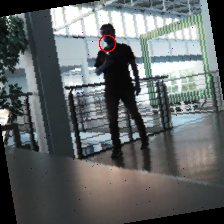

actual


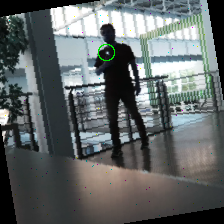

In [90]:
c = 255
# image = to_pil(batch_frames[0][c])
# denorm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
image = denorm(batch_frames[0][c])
image = to_pil(image)

draw = ImageDraw.Draw(image)
x, y = pred[c].tolist()
x, y = x*224/2 +224/2, y*224/2 +224/2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(255,0,0,255), width = 1)
print("prediction")
display(image)

del(image)

# image = to_pil(batch_frames[0][c])
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
image = denorm(batch_frames[0][c])
image = to_pil(image)

draw = ImageDraw.Draw(image)
x, y = batch_target[0][c].tolist()
x, y = (x + 1.)*224./2, (y + 1.)*224./2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(0,225,0,255), width = 1)
print("actual")
display(image)

In [91]:
batch_frames[0].shape[0]

512

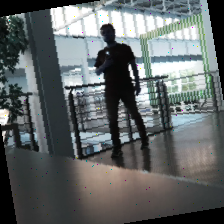

In [92]:
image = denorm(batch_frames[0][c])
image = to_pil(image)
image

In [21]:
# import numpy as np
# from PIL import Image, ImageDraw
# import cv2

# for counter in range(50):
#     videodims = (224,224)
#     fourcc = cv2.VideoWriter_fourcc(*'avc1')    
#     video = cv2.VideoWriter("./vid_224/text.mp4",fourcc, 60, videodims)
#     # img = Image.new('RGB', videodims, color = 'darkred')
#     #draw stuff that goes on every frame here
#     for i in range(0,batch_frames[0].shape[0]):

#         image = denorm(batch_frames[0][i])
#         image = to_pil(image)
#         draw = ImageDraw.Draw(image)
#         x, y = pred[i].tolist()
#         x, y = x*224/2 +224/2, y*224/2 +224/2
#         r = 8
#         leftUpPoint = (x-r, y-r)
#         rightDownPoint = (x+r, y+r)
#         twoPointList = [leftUpPoint, rightDownPoint]
#         draw.ellipse(twoPointList, outline=(255,225,0,255), width = 1)


#     #     imtemp = image#.copy()

#         # draw frame specific stuff here.

#         video.write(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))
#     video.release()
    
#     del(video)
#     del(fourcc)
    

In [31]:
# import numpy as np
# from PIL import Image, ImageDraw
# import cv2
# from IPython.display import Image 
# os.makedirs("./vid_224",exist_ok=True)

# dl = Dataloader_new(args)
# da = Augmentor(args)
# batcher = Batcher(args, dl, da)


# denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
#                                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
#                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
#                                                      std = [ 1., 1., 1. ]),
#                                ])

# to_pil = transforms.ToPILImage()

# for counter in range(25):
#     batch_frames, batch_target = batcher.get_batch()
#     batch_frames = batch_frames[:,:,:3,:,:]
#     videodims = (224,224)
#     fourcc = cv2.VideoWriter_fourcc(*'avc1')    
#     video = cv2.VideoWriter("./vid_224/test_{}.mp4".format(counter),fourcc, 60, videodims)
# #     img = Image.new('RGB', videodims, color = 'darkred')
# #     draw stuff that goes on every frame here
#     for i in range(0,batch_frames[0].shape[0]):

#         image = denorm(batch_frames[0][i])
#         image = to_pil(image)
#         draw = ImageDraw.Draw(image)
#         x, y = batch_target[0][i].tolist()
#         x, y = x*224/2 +224/2, y*224/2 +224/2
#         r = 8
#         leftUpPoint = (x-r, y-r)
#         rightDownPoint = (x+r, y+r)
#         twoPointList = [leftUpPoint, rightDownPoint]
#         draw.ellipse(twoPointList, outline=(255,225,0,255), width = 1)
#         with open("./vid_224/test_{}.txt".format(counter), "a") as file:
#             file.write(str(x) + " " + str(y) + "\n")

#     #     imtemp = image#.copy()

#         # draw frame specific stuff here.

#         video.write(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))
#     video.release()
    
#     del(video)
#     del(fourcc)
#     print("written")
    

../data/video/mi_1.mp4
written
../data/video/video_home_2.mp4
written
../data/video/out_5.mp4
written
../data/video/home_2.mp4
written
../data/video/home_1.mp4
written
../data/video/tum_4.mp4
written
../data/video/video_home_2.mp4
written
../data/video/dark_1.mp4
written
../data/video/home_2.mp4
written
../data/video/out_1.mp4
written
../data/video/dark_2.mp4
written
../data/video/tum_8.mp4
written
../data/video/dark_1.mp4
written
../data/video/home_2.mp4
written
../data/video/tum_6.mp4
written
../data/video/tum_8.mp4
written
../data/video/mary_2.mp4
written
../data/video/mi_2.mp4
written
../data/video/dark_1.mp4
written
../data/video/video_home_2.mp4
written
../data/video/out_2.mp4
written
../data/video/out_2.mp4
written
../data/video/out_2.mp4
written
../data/video/home_1.mp4
written
../data/video/tum_8.mp4
written


In [35]:
dl = Dataloader_new(args)
frames, target = dl.load_vid_and_markup()
# da = Augmentor(args)
# fr, tr = da.apply_transforms(frames, target)

../data/video/temporaly_moved/out_2.mp4


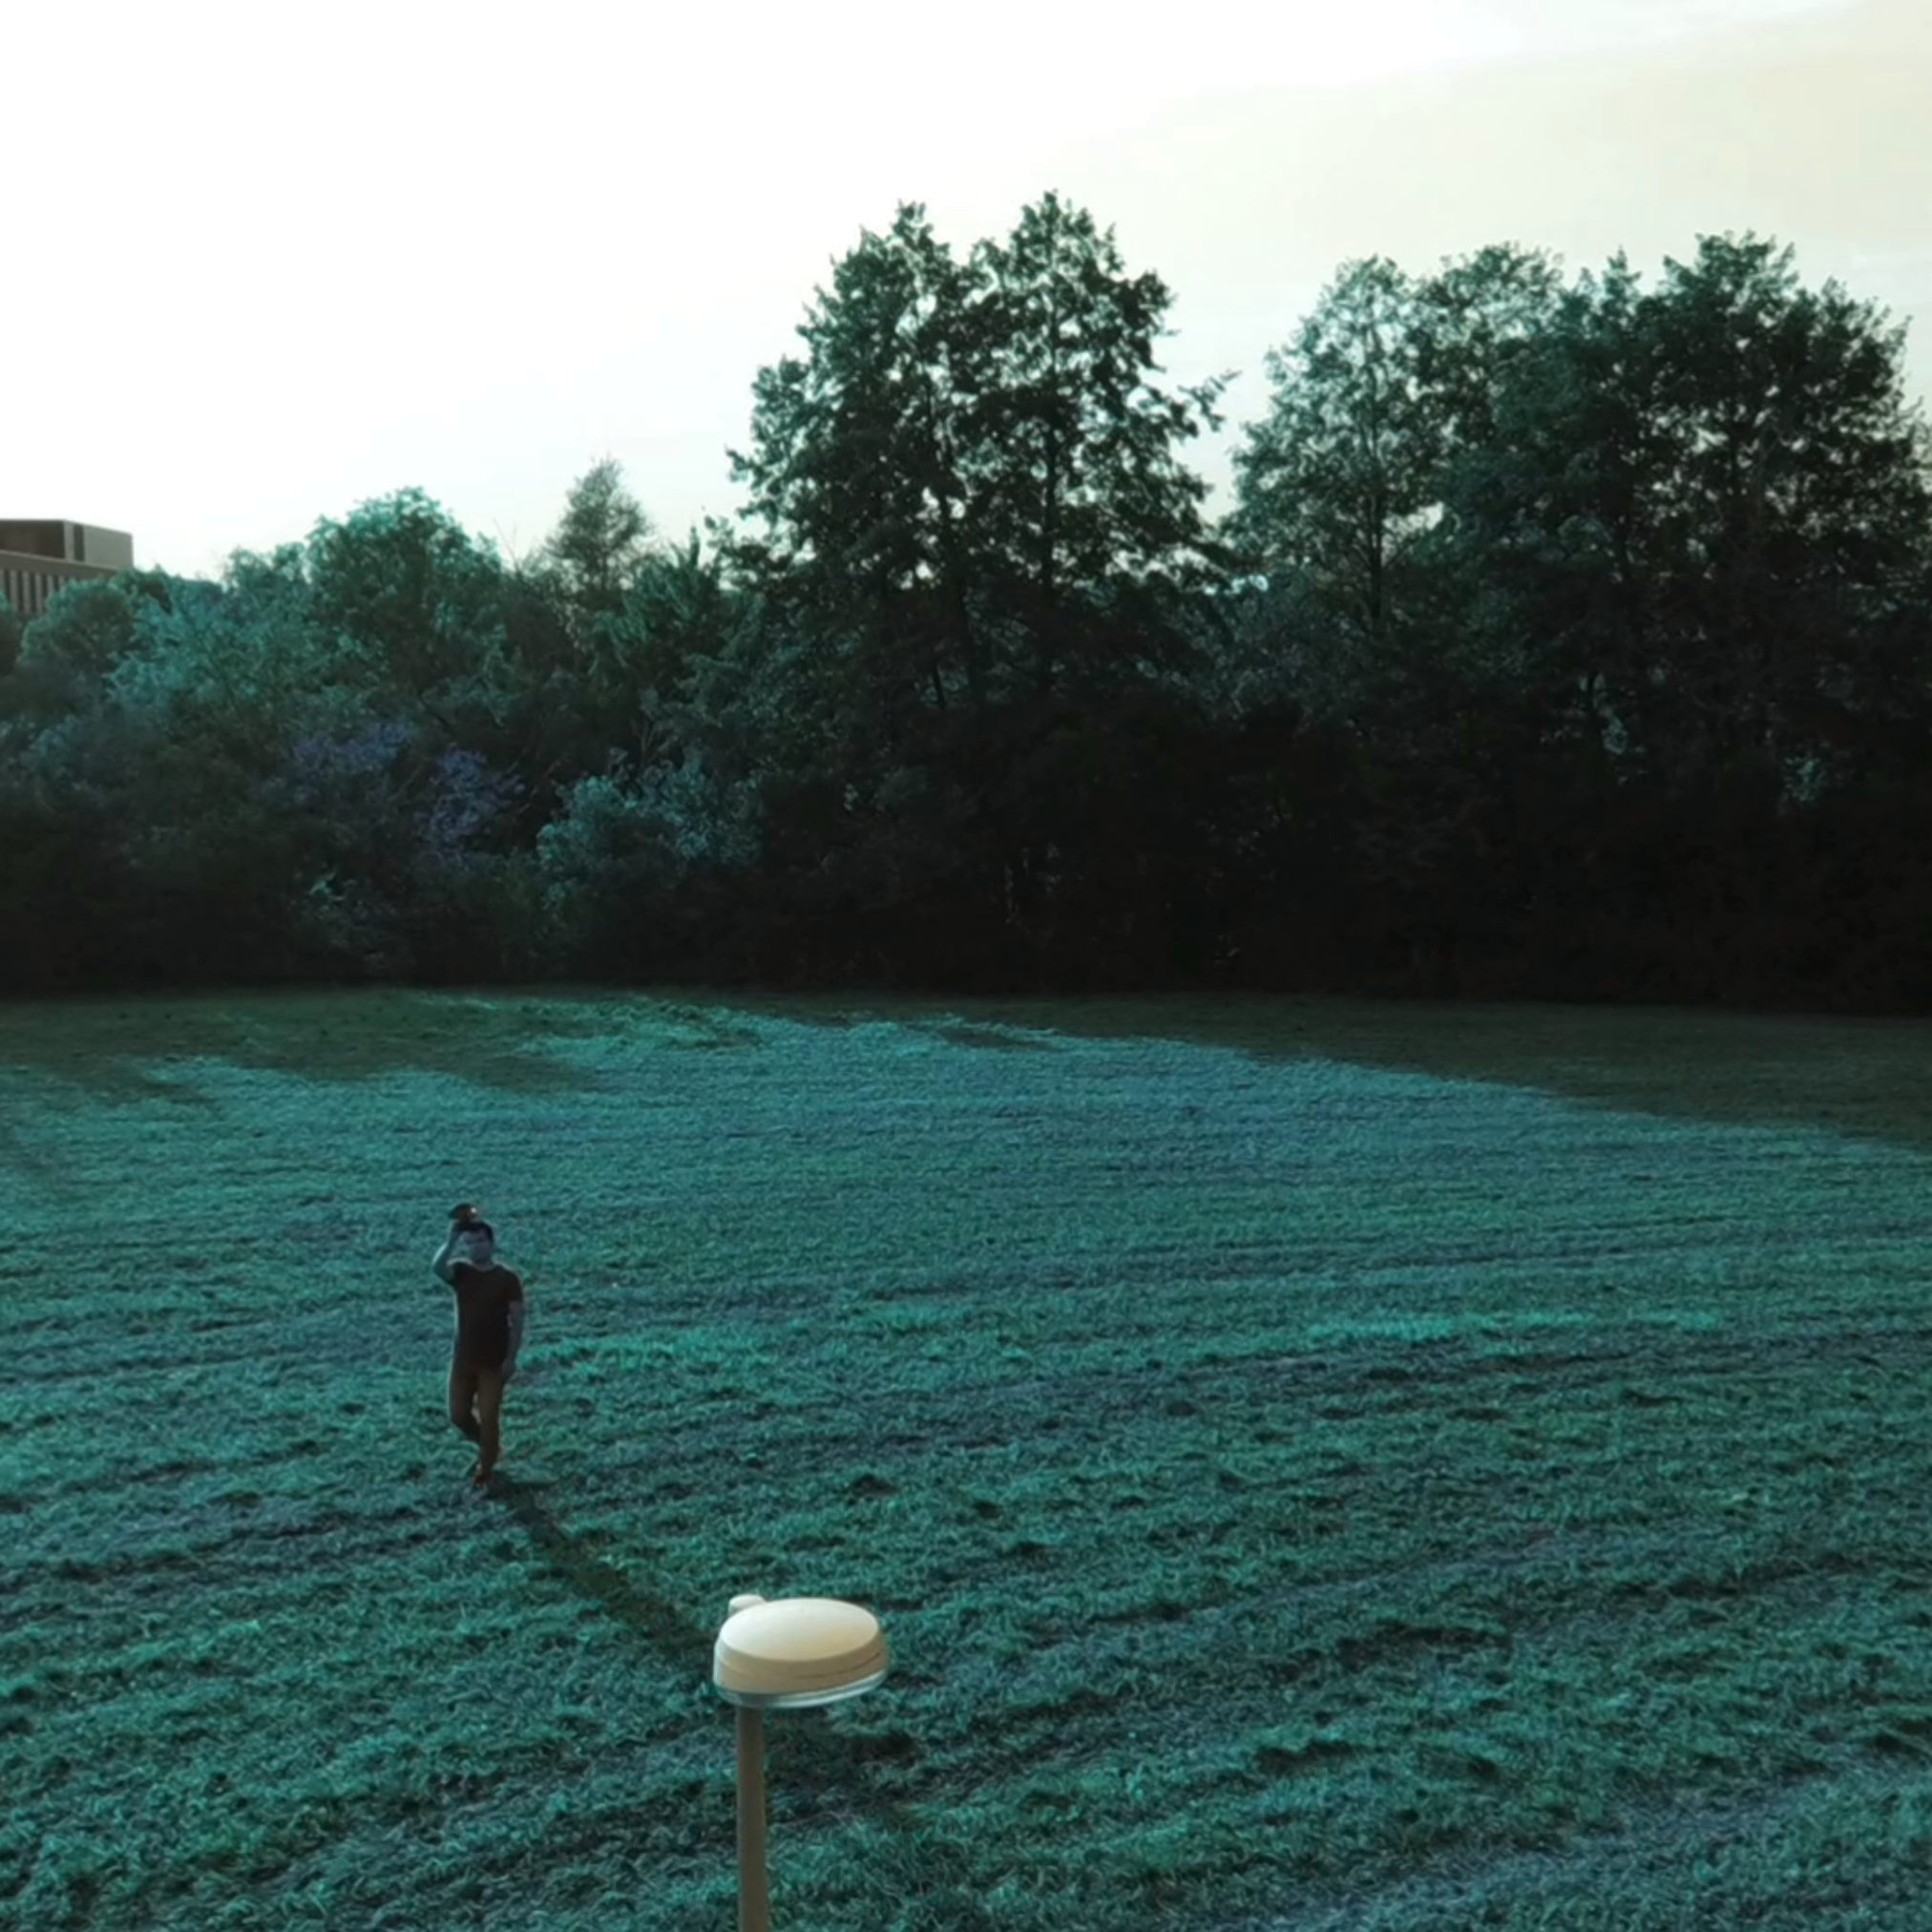

In [52]:
frames[0]

In [39]:
avg_p = nn.AdaptiveAvgPool2d(output_size = (224,224))
max_p = nn.AdaptiveMaxPool2d(output_size = (224,224))

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()
to_pil(avg_p(to_tensor(frames[2])))

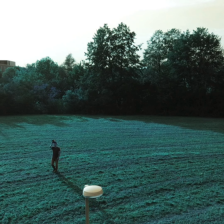

In [40]:
to_pil(avg_p(to_tensor(frames[2])))

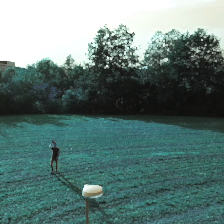

In [58]:
to_pil(max_p(to_tensor(frames[5])))

In [ ]:
transforms.Resize()

In [227]:
batch_frames, batch_target = batcher.get_batch()

../data/video/video_home_2.mp4


In [228]:
to_pil = transforms.ToPILImage()

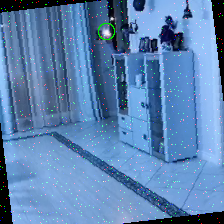

In [229]:
from IPython.display import Image 
c  = 2
image = to_pil(batch_frames[0][c])
draw = ImageDraw.Draw(image)
x, y = batch_target[0][c].tolist()
x, y = (x + 1.)*224./2, (y + 1)*224./2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(0,225,0,255))
display(image)

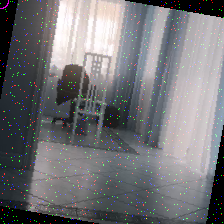

In [45]:
from IPython.display import Image 
c  = 2
image = to_pil(batch_frames[0][c])
draw = ImageDraw.Draw(image)
x, y = batch_target[0][c].tolist()
x, y = (x + 1.)*224./2, (y + 1)*224./2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(225,0,225,255))
display(image)

../data/video/home_1.mp4


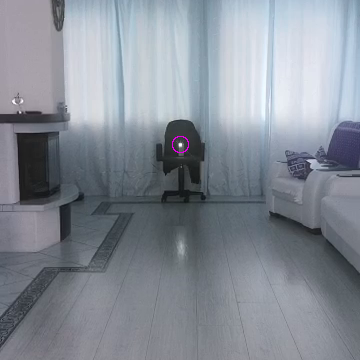

In [149]:
dl = Dataloader_new(args)
frames, target = dl.load_vid_and_markup()
# da = Augmentor(args)
# fr, tr = da.apply_transforms(frames, target)

image = frames[2]
draw = ImageDraw.Draw(image)
x, y = target[2]
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(225,0,225,255))
display(image)

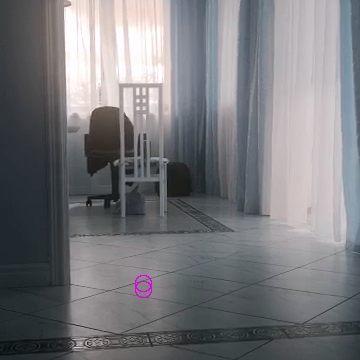

In [108]:
image = frames[2]
draw = ImageDraw.Draw(image)
x, y = target[2][0], 289
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(225,0,225,255))
display(image)

In [77]:
target

tensor([[112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127],
        [112, 127]])

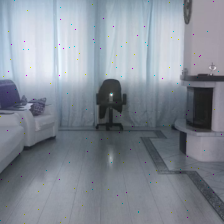

In [48]:
to_pil(batch_frames[0][5])

In [50]:
batch_target[0][5]

tensor([-0.0089,  0.6161])

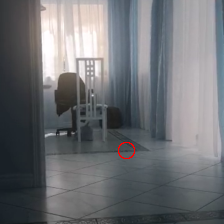

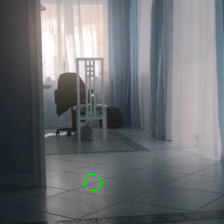

In [86]:
from IPython.display import Image 

c = 15
image = to_pil(batch_frames[0][c])
draw = ImageDraw.Draw(image)
x, y = pred[c].tolist()
x, y = x*224/2 +224/2, y*224/2 +224/2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(255,0,0,255))
display(image)


image = to_pil(batch_frames[0][c])
draw = ImageDraw.Draw(image)
x, y = batch_target[0][c].tolist()
x, y = (x + 1.)*224./2, (y + 1.)*224./2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(0,225,0,255))
display(image)

In [79]:
batch_target[0]

tensor([[-0.1875,  0.6250],
        [-0.1875,  0.6250],
        [-0.1875,  0.6250],
        ...,
        [-0.2411,  0.6607],
        [-0.2411,  0.6607],
        [-0.2411,  0.6607]])

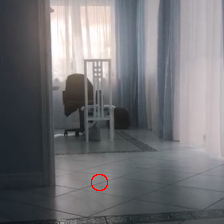

In [85]:
fr, tr = batch_frames[0], batch_target[0]

c = 127
image = to_pil(fr[c])
draw = ImageDraw.Draw(image)
x, y = batch_target[0][c].tolist()
x, y = x*224./2 + 224./2, y*224./2 +224./2
r = 8
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, outline=(255,0,0,255))
image

In [49]:
loss_log

[tensor(154.0053, grad_fn=<MseLossBackward>)]

In [90]:
batch_frames, batch_target = batcher.get_batch()

In [91]:
batch_frames[0].shape

torch.Size([150, 3, 512, 512])

In [92]:
batch_target[0][0]

tensor([253, 234])

In [93]:
to_pil = transforms.ToPILImage()

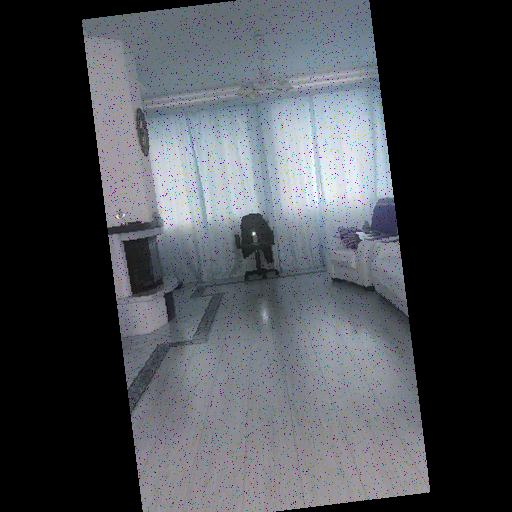

In [100]:
a = to_pil(batch_frames[0][40])
# a.putpixel((266, 229), (255, 0, 0))
a

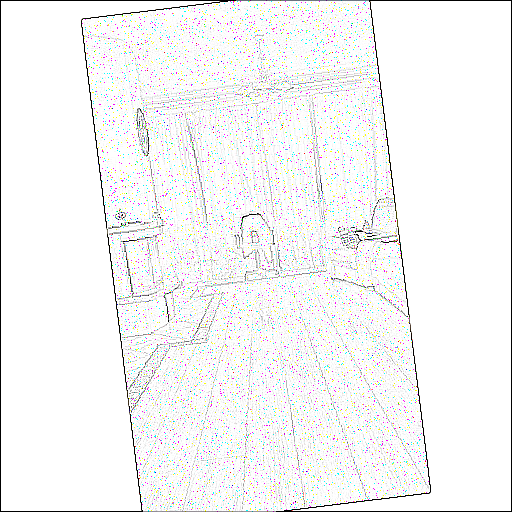

In [128]:
from PIL import ImageFilter

im1 = a.filter(ImageFilter.CONTOUR)

# im2 = a.filter(ImageFilter.Kernel())
# im3 = a.filter(ImageFilter.MinFilter)
im1

In [147]:
im1.mode

'RGB'

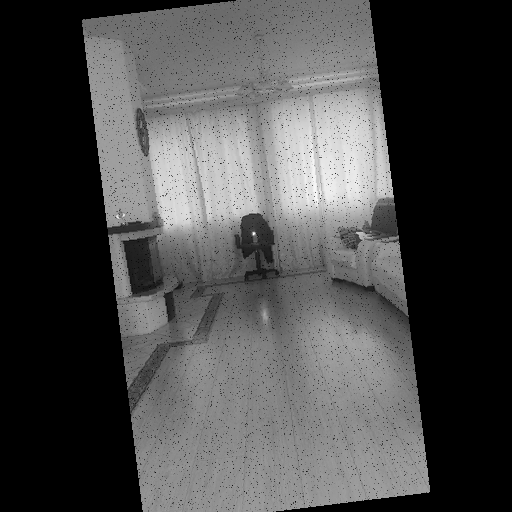

In [105]:
a.convert("L")

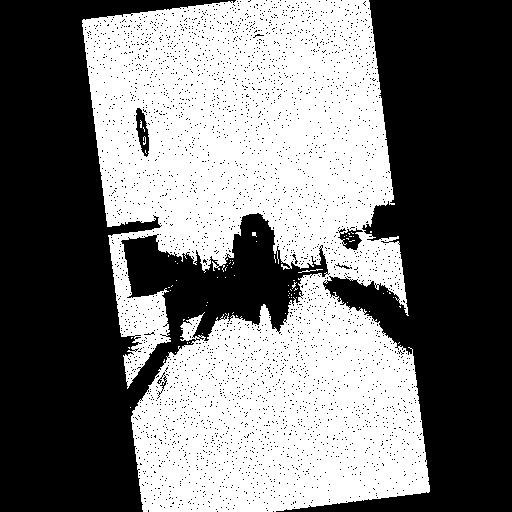

In [118]:
threshold = 100
a.convert("L").point(lambda p: p > threshold and 255)

In [42]:
w

NameError: name 'w' is not defined

In [51]:
fr, tr = batch_frames[0], batch_target[0]
video = cv2.VideoWriter("video_name-3.avi", 0, 1, (args["std_width"], args["std_height"]))

for i, image in enumerate(fr):
    image = to_pil(image)
    trg = tr[i].tolist()
    w, h = trg
    shape = [(w-5, h-5), (w+5, h+5)] 
    img1 = ImageDraw.Draw(image) 
    img1.rectangle(shape, fill =None, outline ="blue") 
    video.write(np.asarray(image))
    #break
cv2.destroyAllWindows()
video.release()
video = None
image = None

In [24]:
to_pil = transforms.ToPILImage()

In [27]:
img = to_pil(batch_frames[0][1])

In [29]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

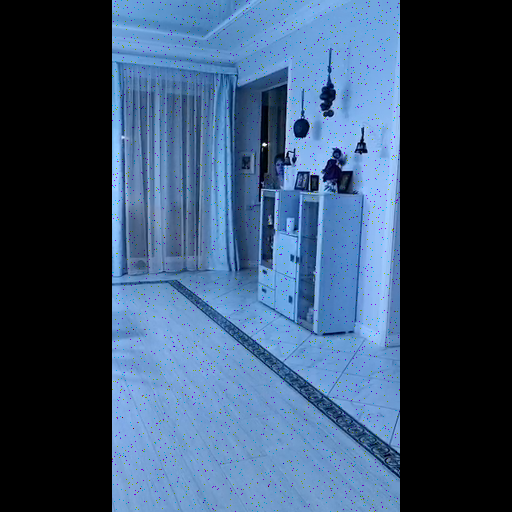

In [31]:
# img = Image.open(FILENAME).convert('RGBA')
arr = np.array(img)
new_img = Image.fromarray(normalize(arr).astype('uint8'))
# new_img.save('/tmp/normalized.png')
new_img

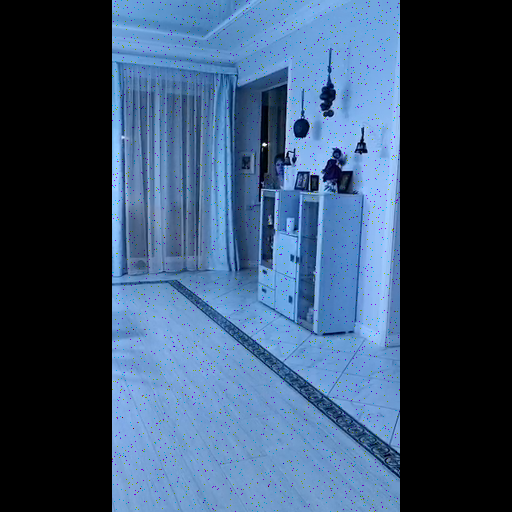

In [32]:
img

In [ ]:
to_pil = transforms.ToPILImage()

In [40]:
for i in loss_log:
    print(i.item(), end = ", ")

3626971.75, 6842022912.0, 781019904.0, 

In [37]:
torch.mean(torch.stack(loss_log))

tensor(2.5422e+09, grad_fn=<MeanBackward0>)

In [2]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/michaelsolonin/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.10MB/s]


In [39]:
batch_frames.shape

torch.Size([3, 150, 3, 512, 512])

In [42]:
for a,b in zip(batch_frames, batch_target):
    break

In [43]:
a.shape

torch.Size([150, 3, 512, 512])

In [44]:
b.shape

torch.Size([150, 2])

In [28]:
pred = pred.squeeze(0)

In [26]:
target.shape

torch.Size([150, 2])

In [22]:
pred.device

device(type='cpu')

In [50]:
mse = nn.MSELoss()

In [51]:
batch_frames.shape

torch.Size([3, 150, 3, 512, 512])

In [53]:
pred[0].shape

torch.Size([150, 2])

In [60]:
target.float().t().shape

torch.Size([2, 150])

In [61]:
mse(pred[0], target.float())

tensor(34546.2305, grad_fn=<MseLossBackward>)

In [34]:
import sys

In [35]:
sys.getsizeof(batch_frames.storage())

1415577672

In [36]:
sum(p.numel() for p in model.parameters())

912426

In [ ]:
torch.cat()

In [1043]:
x = torch.rand(5,5)
x

tensor([[0.7511, 0.7002, 0.8398, 0.9750, 0.0900],
        [0.3278, 0.7455, 0.3319, 0.5708, 0.2130],
        [0.7128, 0.2216, 0.2727, 0.6033, 0.2423],
        [0.4578, 0.1305, 0.6367, 0.9583, 0.9874],
        [0.1533, 0.5119, 0.4546, 0.3821, 0.5480]])

In [1051]:
t = x.clone()

TypeError: copy_() received an invalid combination of arguments - got (), but expected (Tensor other, bool non_blocking)

In [1050]:
t[1,1] = 0

TypeError: 'builtin_function_or_method' object does not support item assignment

In [1047]:
t

tensor([[0.7511, 0.7002, 0.8398, 0.9750, 0.0900],
        [0.3278, 0.0000, 0.3319, 0.5708, 0.2130],
        [0.7128, 0.2216, 0.2727, 0.6033, 0.2423],
        [0.4578, 0.1305, 0.6367, 0.9583, 0.9874],
        [0.1533, 0.5119, 0.4546, 0.3821, 0.5480]])

In [1048]:
x

tensor([[0.7511, 0.7002, 0.8398, 0.9750, 0.0900],
        [0.3278, 0.0000, 0.3319, 0.5708, 0.2130],
        [0.7128, 0.2216, 0.2727, 0.6033, 0.2423],
        [0.4578, 0.1305, 0.6367, 0.9583, 0.9874],
        [0.1533, 0.5119, 0.4546, 0.3821, 0.5480]])

In [ ]:
t = t_frames[0]
t = conv(t)
t = t.view(t.shape[0], -1)
t = fc1(t).unsqueeze(0)
t = gru(t)
t = t[0].squeeze(0)
t = fc2(t)

In [1040]:
args["hidden_dim"]

128

In [552]:
video = cv2.VideoWriter("video_name-1.avi", 0, 1, frames[0].size)

for i, image in enumerate(frames):
    trg = target[i].tolist()
    w, h = trg
    shape = [(w-5, h-5), (w+5, h+5)] 
    img1 = ImageDraw.Draw(image) 
    img1.rectangle(shape, fill =None, outline ="blue") 
    video.write(np.asarray(image))
    #break
cv2.destroyAllWindows()
video.release()
video = None
image = None

In [964]:
fr, tr = da.apply_transforms(frames, target)
video = cv2.VideoWriter("video_name-2.avi", 0, 1, frames[0].size)

for i, image in enumerate(fr):
    trg = tr[i].tolist()
    w, h = trg
    shape = [(h-5, w-5), (h+5, w+5)] 
    img1 = ImageDraw.Draw(image) 
    img1.rectangle(shape, fill =None, outline ="blue") 
    video.write(np.asarray(image))
    #break
cv2.destroyAllWindows()
video.release()
video = None
image = None

In [10]:
class Batcher(nn.Module):
    def __init__(self, args):
        super(Batcher, self).__init__()
        self.args = args
#     def get_batch():
#         for i in range(self.args["batch_size"])

In [221]:
!pwd

/Users/michaelsolonin/Desktop/Flash_detection/notebook


In [175]:
class Dataloader_old(nn.Module):
    def __init__(self, args):
        super(Dataloader, self).__init__()
        self.args = args
        self.list_videos = [f for f in os.listdir(args["video_path"]) if isfile(join(args["video_path"],f))]
        self.list_weights = [int(cv2.VideoCapture(str(self.args["video_path"]/vid))\
                                 .get(cv2.CAP_PROP_FRAME_COUNT))
                            for vid in self.list_videos]
        self.to_standart = transforms.Compose([transforms.Resize((args["std_height"],args["std_width"]))])
        self.to_pil = transforms.ToPILImage()
        self.arr_weights = np.array(self.list_weights)
        self.choice_probs = self.arr_weights / sum(self.arr_weights)
        
    def get_new_target(self, old_x, old_y, old_max_h, old_max_w, new_max_h, new_max_w):
        """
        Returns new target x, y for resized frame
        args:
            old_x [int] - old x component of target position of single frame
            old_y [int] - old y component of target position of single frame
            old_max_h [int] - height of original frame
            old_max_w [int] - width of original frame
            new_max_h [int] - height of resized frame
            new_max_w [int] - width of resized frame
        return:
            new_x, new_y [int, int] - target position for resized frame
        """
        new_x = old_x#int( (old_x + 0) / old_max_w * new_max_w - 0)
        new_y = old_y#int( (old_y + 0) / old_max_h * new_max_h - 0)
        return new_x, new_y
    def load_vid_and_markup(self):
        """
        Loads video as list of frames (PIL images) and markup as list of (x,y) - target position
        return:
            frames_list [max_seq_len, in_channels, std_height, std_width]
            target_list [max_seq_len, 2]
        """
        video_name = np.random.choice(self.list_videos,replace=False, p = self.choice_probs)
        # get markup
        with open(self.args["markup_path"] / (video_name + ".markup.json")) as json_file:
            j = json.load(json_file)
            lst_tmp = j["target_pos"]
            old_h = j["height"]
            old_w = j["width"]
            scale_params = [old_h, old_w, self.args["std_height"], self.args["std_width"]]
            target_unscaled_all = [xi[1] for xi in lst_tmp]
            targets_scaled_all = [self.get_new_target(*xy_pair, *scale_params) 
                                  for xy_pair in target_unscaled_all]
            target_points = torch.tensor(targets_scaled_all) 
        # get video frames
        vid_path = str(self.args["video_path"] / (video_name))
        cap = cv2.VideoCapture(vid_path)
        frames_list = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            #TODO: make it optimal
            frame = self.to_pil(frame)
            frame = self.to_standart(frame)
            frames_list.append(frame)
        # prepare output
        assert len(frames_list) == target_points.shape[0]
        cur_length = len(frames_list)
        if cur_length > self.args["max_seq_len"]:
            # get a truncated part of the video
            begin = np.random.randint(low=0, high= cur_length - self.args["max_seq_len"])
            end = begin + self.args["max_seq_len"]
            frames_fin = frames_list[begin:end]
            target_fin = target_points[begin:end, :]
        else:
            # complement to standard size
            add_size = self.args["max_seq_len"] - cur_length
            frames_to_add = [self.to_pil(torch.zeros(frames_list[0].size)) 
                      for i in range(add_size)]
            target_to_add = torch.zeros([add_size, 2], dtype=torch.long)
            
            frames_fin = frames_list + frames_to_add
            target_fin = torch.cat([target_points, target_to_add], dim = 0)
        return frames_fin, target_fin

In [238]:
frames = out[0]
target = out[1]

In [239]:
# c = 15

# h, w = out[1][c][1], out[1][c][0]
# shape = [(w, h), (w, h)] 
# #shape = [(0,0),(0,0)] 
# # creating new Image object 
# img = out[0][c]
  
# # create rectangle image 
# img1 = ImageDraw.Draw(img)   
# img1.rectangle(shape, fill ="#ffff33", outline ="red") 
# img.show() 

In [240]:
frames[0].size

(700, 700)

In [11]:
dl = Dataloader(args)
out = dl.load_vid_and_markup()

In [72]:
sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    va.RandomCrop(size=(240, 180)), # randomly crop video with a size of (240 x 180)
    va.RandomRotate(degrees=10), # randomly rotates the video with a degree randomly choosen from [-10, 10] 
    va.Salt()
    #sometimes(va.HorizontalFlip()) # horizontally flip the video with 50% probability
])

In [94]:
frames, target = out

In [95]:
target

tensor([[186, 194],
        [186, 193],
        [186, 193],
        [186, 193],
        [186, 193],
        [186, 193],
        [185, 197],
        [188, 192],
        [188, 192],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [188, 194],
        [187, 193],
        [187, 193],
        [188, 193],
        [188, 193],
        [188, 193],
        [188, 195],
        [188, 195],
        [186, 194],
        [186, 194],
        [188, 193],
        [187, 195],
        [186, 192],
        [187, 192],
        [187, 193],
        [187, 195],
        [189, 194],
        [189, 194],
        [189, 194],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],
        [187, 193],


In [76]:
frames[0].size

(326, 256)

In [79]:
t = torch.zeros(args["std_width"], args["std_height"])

In [97]:
lst_target = []
for i in range(len(frames)):
    t = torch.zeros(args["std_height"], args["std_width"])
    w, h = target[i].tolist()
    t[w, h] = 1
    lst_target.append(t)
#     t[]

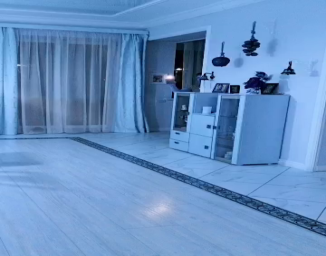

In [98]:
frames[0]

In [90]:
len(frames)

150

In [82]:
target[13]

tensor([170,  77])

In [107]:
tt = to_tensor(to_pil(lst_target[0]))
(tt == 1).nonzero()

tensor([[  0, 186, 194]])

In [108]:
tt.shape

torch.Size([1, 256, 326])

In [109]:
target[2]

tensor([186, 193])

In [114]:
t[186, 193]

tensor(0.)

In [44]:
dl = Dataloader(args)
out = dl.load_vid_and_markup()

NameError: name 'arr_weights' is not defined

In [143]:
from PIL import Image, ImageDraw 

In [104]:
c = 15

h, w = out[1][c][1], out[1][c][0]
shape = [(w, h), (w, h)] 
#shape = [(0,0),(0,0)] 
# creating new Image object 
img = out[0][c]
  
# create rectangle image 
img1 = ImageDraw.Draw(img)   
img1.rectangle(shape, fill ="#ffff33", outline ="red") 
img.show() 

In [105]:
to_standart = transforms.Compose([transforms.Resize((args["std_height"],args["std_width"]))])
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

vid_path = str(args["video_path"] / 'video_home_11.mp4')
cap = cv2.VideoCapture(vid_path)
frames_list = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    #TODO: make it optimal
    frame = to_pil(frame)
    #frame = to_standart(frame)
    frames_list.append(frame)

with open(args["markup_path"] / ('video_home_11.mp4' + ".markup.json")) as json_file:
    j = json.load(json_file)
    lst_tmp = j["target_pos"]
    old_h = j["height"]
    old_w = j["width"]
    scale_params = [old_h, old_w, args["std_height"], args["std_width"]]
    target_unscaled_all = [xi[1] for xi in lst_tmp]

c = 15
h, w = target_unscaled_all[c][1], target_unscaled_all[c][0],
shape = [(w, h), (w, h)] 
#shape = [(0,0),(0,0)] 
# creating new Image object 
img = frames_list[c]
  
# create rectangle image 
img1 = ImageDraw.Draw(img)   
img1.rectangle(shape, fill ="#ffff33", outline ="red") 
img.show() 

In [147]:
b

array([165,  77])

In [146]:
w, h = b
shape = [(w, h), (w, h)] 
img = a
img1 = ImageDraw.Draw(img)   
img1.rectangle(shape, fill ="#ffff33", outline ="red") 
img.show() 

In [23]:
out[1][0].tolist()

[168, 77]

In [84]:
w, h

(194, 186)

In [123]:
len(frames_list)

119

In [124]:
args["max_seq_len"]

100

In [135]:
cur_length = 41
to_add = [to_pil(torch.zeros(frames_list[0].size)) for i in range(args["max_seq_len"] - cur_length)]


In [ ]:
torch.cat()

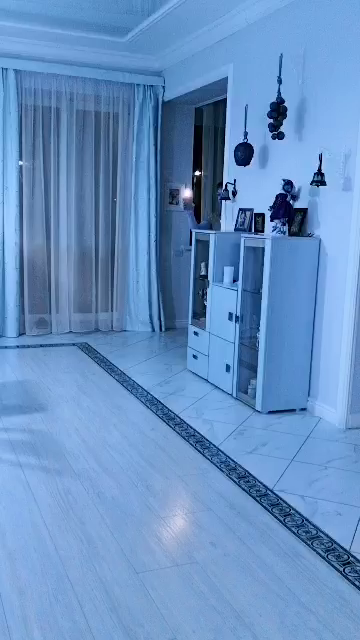

In [25]:
frames_list[0]

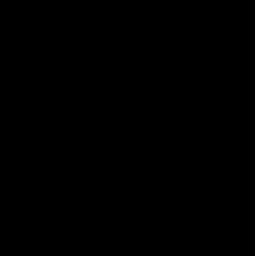

In [138]:
to_add[0]

In [133]:
frames_list[0].size

(256, 255)

In [23]:
to_standart = transforms.Compose([transforms.Resize((args["std_height"],args["std_width"]))])
to_pil = transforms.ToPILImage()
        

In [30]:
to_standart = transforms.Compose([transforms.Resize((args["std_height"],args["std_width"]))])
to_pil = transforms.ToPILImage()

vid_path = str(args["video_path"] / 'video_home_11.mp4')
cap = cv2.VideoCapture(vid_path)
frames_list = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    #TODO: make it optimal
    frame = to_pil(frame)
    #frame = to_standart(frame)
    frames_list.append(frame)

In [19]:
random.choice([f for f in os.listdir(args["video_path"]) if isfile(join(args["video_path"],f))])

'video_home_11.mp4'

In [108]:
np.random.randint(low = 0, high = 10 - 5)

0

In [120]:
t = torch.rand(10, 2)
print(t)

t[1:5, :]

tensor([[0.5981, 0.7967],
        [0.8455, 0.1867],
        [0.0539, 0.9638],
        [0.8175, 0.2596],
        [0.1682, 0.4210],
        [0.0898, 0.5507],
        [0.5310, 0.3444],
        [0.0766, 0.5957],
        [0.9790, 0.9161],
        [0.1944, 0.5772]])


tensor([[0.8455, 0.1867],
        [0.0539, 0.9638],
        [0.8175, 0.2596],
        [0.1682, 0.4210]])

In [111]:
[1,2,3,4,5][3:10]

[4, 5]

In [89]:
def get_new_target(old_x, old_y, old_max_h, old_max_w, new_max_h, new_max_w):
    """
    Returns new target x, y for resized frame
    args:
        old_x [int] - old x component of target position of single frame
        old_y [int] - old y component of target position of single frame
        old_max_h [int] - height of original frame
        old_max_w [int] - width of original frame
        new_max_h [int] - height of resized frame
        new_max_w [int] - width of resized frame
    return:
        new_x, new_y [int, int] - target position for resized frame
    """
    new_x = int( (old_x + 0) / old_max_h * new_max_h - 0)
    new_y = int( (old_y + 0) / old_max_w * new_max_w - 0)
    return new_x, new_y

In [90]:
l_orig = [
    [0,0],
    [1,1],
    [9,9],
    [7,8]
]
orig_h = 640
orig_w = 360
new_h = 200
new_w = 200

In [93]:
torch.tensor([get_new_target(*l_orig[i], orig_h, orig_w, new_h, new_w) for i in range(len(l_orig))])

tensor([[0, 0],
        [0, 0],
        [2, 5],
        [2, 4]])

In [88]:
9 / 640, 3/200

(0.0140625, 0.015)

In [95]:
frames_list.__len__()

119

In [44]:
vid_path = str(args["video_path"] / 'video_home_11.mp4')
cap = cv2.VideoCapture(vid_path)
frames_list = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    #TODO: make it optimal
    frames_list.append(frame)

In [51]:
frames_list[0].shape

(640, 360, 3)

In [33]:


[np.array(xi[1]) for xi in lst_tmp]

[array([187, 197]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([186, 193]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),
 array([0, 0]),


In [64]:
with open(args["markup_path"] / ('video_home_11.mp4' + ".markup.json")) as json_file:
    j = json.load(json_file)
    lst_tmp = j["target_pos"]
    target_points_all = torch.tensor([np.array(xi[1]) for xi in lst_tmp])

In [25]:
to_standart = transforms.Compose([transforms.Resize((args["std_hight"],args["std_width"]))])
to_pil = transforms.ToPILImage()

vid_path = str(args["video_path"] / 'video_home_11.mp4')
cap = cv2.VideoCapture(vid_path)
frames_list = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    #TODO: make it optimal
    frame = to_pil(frame)
    frame = to_standart(frame)
    frames_list.append(frame)

In [ ]:
127 / 

In [ ]:
np.load()

In [ ]:
class  CharCNN(nn.Module):
    def __init__(self, args):
        super(CharCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(args["char_emb_dim"], 128, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
        ) 
        
        self.fc1 = nn.Sequential( 
            nn.Linear(320, 128),   ### fix param here
            nn.Sigmoid(),
            nn.Dropout(p=args["dropout"])
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(128, args["char_emb_out"]),
            #nn.ReLU(),
            #nn.Dropout(p=args["dropout"])
        )

    def forward(self, x):
#        print("~"*12)
#        print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x = self.fc2(x)
        
        return x

In [31]:
def get_new_target(self, old_x, old_y, old_max_h, old_max_w, new_max_h, new_max_w)
    """
    Returns new target x, y for resized frame
    args:
        old_x [int] - old x component of target position of single frame
        old_y [int] - old y component of target position of single frame
        old_max_h [int] - height of original frame
        old_max_w [int] - width of original frame
        new_max_h [int] - height of resized frame
        new_max_w [int] - width of resized frame
    return:
        new_x, new_y [int, int] - target position for resized frame
    """
    new_x = round( old_x / old_max_h * new_max_h)
    new_y = round( old_y / old_max_w * new_max_w)
    return new_x, new_y
target_points_all.map_()

torch.Size([119, 2])

In [ ]:
class Dataloader_old(nn.Module):
    def __init__(self, args):
        super(Dataloader, self).__init__()
        self.args = args
        self.list_videos = [f for f in os.listdir(args["video_path"]) if isfile(join(args["video_path"],f))]
        self.list_weights = [int(cv2.VideoCapture(str(self.args["video_path"]/vid))\
                                 .get(cv2.CAP_PROP_FRAME_COUNT))
                            for vid in self.list_videos]
        self.to_standart = transforms.Compose([transforms.Resize((args["std_height"],args["std_width"]))])
        self.to_pil = transforms.ToPILImage()
        self.arr_weights = np.array(self.list_weights)
        self.choice_probs = self.arr_weights / sum(self.arr_weights)
        
    def get_new_target(self, old_x, old_y, old_max_h, old_max_w, new_max_h, new_max_w):
        """
        Returns new target x, y for resized frame
        args:
            old_x [int] - old x component of target position of single frame
            old_y [int] - old y component of target position of single frame
            old_max_h [int] - height of original frame
            old_max_w [int] - width of original frame
            new_max_h [int] - height of resized frame
            new_max_w [int] - width of resized frame
        return:
            new_x, new_y [int, int] - target position for resized frame
        """
        new_x = old_x#int( (old_x + 0) / old_max_w * new_max_w - 0)
        new_y = old_y#int( (old_y + 0) / old_max_h * new_max_h - 0)
        return new_x, new_y
    def load_vid_and_markup(self):
        """
        Loads video as list of frames (PIL images) and markup as list of (x,y) - target position
        return:
            frames_list [max_seq_len, in_channels, std_height, std_width]
            target_list [max_seq_len, 2]
        """
        video_name = np.random.choice(self.list_videos,replace=False, p = self.choice_probs)
        # get markup
        with open(self.args["markup_path"] / (video_name + ".markup.json")) as json_file:
            j = json.load(json_file)
            lst_tmp = j["target_pos"]
            old_h = j["height"]
            old_w = j["width"]
            scale_params = [old_h, old_w, self.args["std_height"], self.args["std_width"]]
            target_unscaled_all = [xi[1] for xi in lst_tmp]
            targets_scaled_all = [self.get_new_target(*xy_pair, *scale_params) 
                                  for xy_pair in target_unscaled_all]
            target_points = torch.tensor(targets_scaled_all) 
        # get video frames
        vid_path = str(self.args["video_path"] / (video_name))
        cap = cv2.VideoCapture(vid_path)
        frames_list = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            #TODO: make it optimal
            frame = self.to_pil(frame)
            frame = self.to_standart(frame)
            frames_list.append(frame)
        # prepare output
        assert len(frames_list) == target_points.shape[0]
        cur_length = len(frames_list)
        if cur_length > self.args["max_seq_len"]:
            # get a truncated part of the video
            begin = np.random.randint(low=0, high= cur_length - self.args["max_seq_len"])
            end = begin + self.args["max_seq_len"]
            frames_fin = frames_list[begin:end]
            target_fin = target_points[begin:end, :]
        else:
            # complement to standard size
            add_size = self.args["max_seq_len"] - cur_length
            frames_to_add = [self.to_pil(torch.zeros(frames_list[0].size)) 
                      for i in range(add_size)]
            target_to_add = torch.zeros([add_size, 2], dtype=torch.long)
            
            frames_fin = frames_list + frames_to_add
            target_fin = torch.cat([target_points, target_to_add], dim = 0)
        return frames_fin, target_fin